In [119]:
import numpy as np
import pandas as pd
import warnings

from numba import jit
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import NearestNeighbors


@jit(nopython=True, fastmath=True)
def compute_errors_numba(neighbor_clouds, max_iter=50, eps=1e-5):
    n_samples, k, dim = neighbor_clouds.shape
    errors = np.empty(n_samples, dtype=np.float64)

    for i in range(n_samples):
        cloud = neighbor_clouds[i]

        y = np.zeros(dim)
        for d in range(dim):
            s = 0.0
            for j in range(k):
                s += cloud[j, d]
            y[d] = s / k

        for _ in range(max_iter):
            sum_weights = 0.0
            y_next = np.zeros(dim)
            all_non_zero = True

            for j in range(k):
                dist_sq = 0.0
                for d in range(dim):
                    diff = cloud[j, d] - y[d]
                    dist_sq += diff * diff
                dist = np.sqrt(dist_sq)

                if dist < 1e-10:
                    all_non_zero = False
                    for d in range(dim):
                        y[d] = cloud[j, d]
                    break

                w = 1.0 / dist
                sum_weights += w
                for d in range(dim):
                    y_next[d] += cloud[j, d] * w

            if not all_non_zero:
                break

            diff_norm_sq = 0.0
            for d in range(dim):
                y_next[d] /= sum_weights
                diff = y[d] - y_next[d]
                diff_norm_sq += diff * diff
                y[d] = y_next[d]

            if np.sqrt(diff_norm_sq) < eps:
                break

        total_dist = 0.0
        for j in range(k):
            dist_sq = 0.0
            for d in range(dim):
                diff = cloud[j, d] - y[d]
                dist_sq += diff * diff
            total_dist += np.sqrt(dist_sq)

        errors[i] = total_dist / k

    return errors


def check_embedding_condition(data, threshold=1e10):
    data_centered = data - np.mean(data, axis=0)
    s = np.linalg.svdvals(data_centered)
    if s[-1] < 1e-12:
        return np.inf
    return s[0] / s[-1]


def estimate_intrinsic_stochasticity(
    embedding_data,
    pushforward,
    k=50,
    n_samples=5000,
    cond_threshold=1000,
    random_state=0,
    theiler_w=0,
    buffer_mult=6,
    pre_scaled=False,
    strict_theiler=True,
):
    if pre_scaled:
        data_norm = np.asarray(embedding_data)
    else:
        data_norm = RobustScaler().fit_transform(np.asarray(embedding_data))

    cond_num = check_embedding_condition(data_norm)
    if (cond_num > cond_threshold) or np.isinf(cond_num):
        warnings.warn(f"Rank deficient: cond={cond_num:.2e}")
        return None

    T = data_norm.shape[0]
    max_start = T - pushforward

    X_curr = data_norm[:max_start]
    Y_fut = data_norm[pushforward:]

    rng = np.random.default_rng(random_state)
    n_q = int(min(n_samples, max_start))
    query_idx = rng.choice(max_start, size=n_q, replace=False)

    k_query = int(min(max_start, max(k * buffer_mult, k + 2 * theiler_w + 5)))
    nbrs = NearestNeighbors(n_neighbors=k_query, n_jobs=-1).fit(X_curr)
    dist_raw, idx_raw = nbrs.kneighbors(X_curr[query_idx])

    nn_idx = np.empty((n_q, k), dtype=np.int64)

    for r in range(n_q):
        q = int(query_idx[r])
        cand = idx_raw[r]

        picked = 0
        for j in range(k_query):
            t = int(cand[j])
            if t == q:
                continue
            if theiler_w > 0 and abs(t - q) <= theiler_w:
                continue
            nn_idx[r, picked] = t
            picked += 1
            if picked == k:
                break

        if picked < k:
            if strict_theiler:
                raise RuntimeError(f"Not enough neighbors: picked={picked} < k={k}")
            picked2 = 0
            for j in range(k_query):
                t = int(cand[j])
                if t == q:
                    continue
                nn_idx[r, picked2] = t
                picked2 += 1
                if picked2 == k:
                    break

    neighbor_clouds = Y_fut[nn_idx]
    local_errors = compute_errors_numba(neighbor_clouds)
    return float(np.mean(local_errors))


def finite_diff(x, dt):
    return np.gradient(x, dt)


def build_F1_theta(theta, omega, acc, jerk):
    return np.column_stack([theta, omega, acc, jerk]).astype(np.float64)


def build_F2_sin_theta(theta, omega, acc, jerk):
    s = np.sin(theta)
    c = np.cos(theta)
    return np.column_stack([s, c * omega, c * acc - s * (omega**2), c * jerk - 3.0 * s * omega * acc - c * (omega**3)]).astype(np.float64)


def load_real_mat(fname):
    from scipy.io import loadmat
    M = loadmat(fname)
    The1 = np.asarray(M["The1"]).squeeze().astype(np.float64)
    The2 = np.asarray(M["The2"]).squeeze().astype(np.float64)
    dThe1 = np.asarray(M["dThe1"]).squeeze().astype(np.float64)
    dThe2 = np.asarray(M["dThe2"]).squeeze().astype(np.float64)
    ddThe1 = np.asarray(M["ddThe1"]).squeeze().astype(np.float64)
    ddThe2 = np.asarray(M["ddThe2"]).squeeze().astype(np.float64)
    The1 = np.unwrap(The1)
    The2 = np.unwrap(The2)
    return The1, The2, dThe1, dThe2, ddThe1, ddThe2


k = 100
pushforward_list = [500, 700, 900, 1100, 1300, 1500, 1700, 2000]
theiler_w = 200
n_samples = 5000
buffer_mult = 10
random_state = 0

dt_real = 0.001

mat_name = "Stady_Data.mat_Final_Result_17_9_5_4.996.mat"
dat_name = "doublependulum.dat"

The1, The2, dThe1, dThe2, ddThe1, ddThe2 = load_real_mat(mat_name)
dddThe1 = finite_diff(ddThe1, dt_real)
dddThe2 = finite_diff(ddThe2, dt_real)

F1_real_theta2 = build_F1_theta(The2, dThe2, ddThe2, dddThe2)
F2_real_theta2 = build_F2_sin_theta(The2, dThe2, ddThe2, dddThe2)

F1_real_theta1 = build_F1_theta(The1, dThe1, ddThe1, dddThe1)
F2_real_theta1 = build_F2_sin_theta(The1, dThe1, ddThe1, dddThe1)

def Estar(series4d, pushforward):
    out = estimate_intrinsic_stochasticity(
        embedding_data=series4d,
        pushforward=pushforward,
        k=k,
        n_samples=n_samples,
        cond_threshold=1000,
        random_state=random_state,
        theiler_w=theiler_w,
        buffer_mult=buffer_mult,
        pre_scaled=False,
        strict_theiler=True,
    )
    return out

rows = []
for pf in pushforward_list:
    rows.append(("REAL", "theta2", "F1(theta)", pf, Estar(F1_real_theta2, pf)))
    rows.append(("REAL", "theta2", "F2(sinθ)", pf, Estar(F2_real_theta2, pf)))

    rows.append(("REAL", "theta1", "F1(theta)", pf, Estar(F1_real_theta1, pf)))
    rows.append(("REAL", "theta1", "F2(sinθ)", pf, Estar(F2_real_theta1, pf)))

df = pd.DataFrame(rows, columns=["dataset", "angle", "embedding", "pushforward", "E_star"])
df["k"] = k
df["theiler_w"] = theiler_w
df["n_samples"] = n_samples

print(df.to_string(index=False))
df.to_csv("Results_double_pendulum.csv", index=False)

dataset  angle embedding  pushforward   E_star   k  theiler_w  n_samples
   REAL theta2 F1(theta)          500 0.107863 100        200       5000
   REAL theta2  F2(sinθ)          500 0.160123 100        200       5000
   REAL theta1 F1(theta)          500 0.080691 100        200       5000
   REAL theta1  F2(sinθ)          500 0.108261 100        200       5000
   REAL theta2 F1(theta)          700 0.108146 100        200       5000
   REAL theta2  F2(sinθ)          700 0.181893 100        200       5000
   REAL theta1 F1(theta)          700 0.078519 100        200       5000
   REAL theta1  F2(sinθ)          700 0.123028 100        200       5000
   REAL theta2 F1(theta)          900 0.109860 100        200       5000
   REAL theta2  F2(sinθ)          900 0.187892 100        200       5000
   REAL theta1 F1(theta)          900 0.080222 100        200       5000
   REAL theta1  F2(sinθ)          900 0.123799 100        200       5000
   REAL theta2 F1(theta)         1100 0.117782 100 

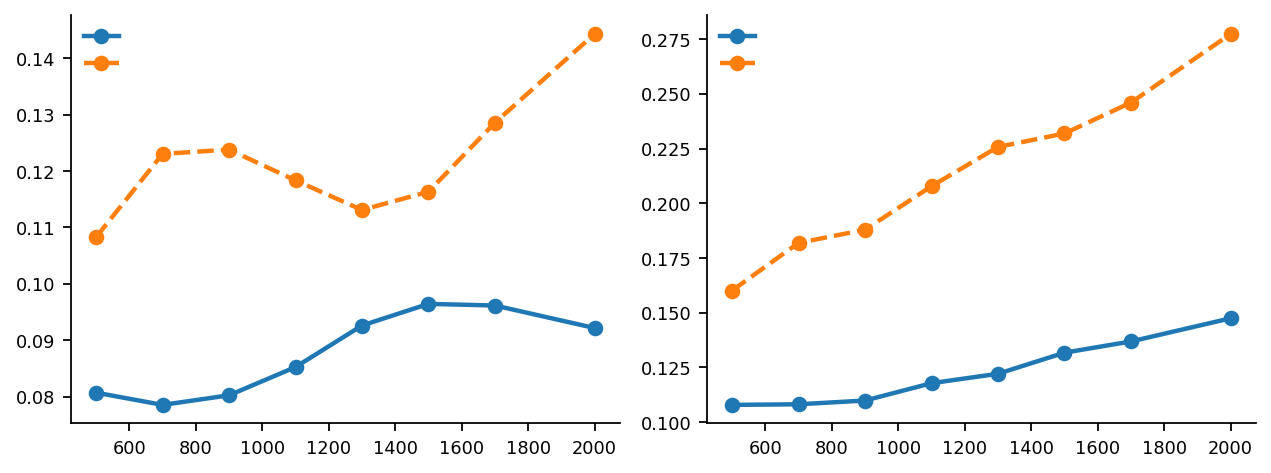

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.dpi": 160,
    "savefig.dpi": 300,
    "font.size": 8,
    "axes.titlesize": 8,
    "axes.labelsize": 8,
    "legend.fontsize": 8,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

df_plot = df.sort_values(["dataset", "angle", "pushforward", "embedding"]).copy()

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharex=True)
axes = axes.ravel()

panels = [("REAL", "theta1"), ("REAL", "theta2")]

for ax, (dataset, angle) in zip(axes, panels):
    g = df_plot[(df_plot["dataset"] == dataset) & (df_plot["angle"] == angle)].copy()
    g = g.sort_values("pushforward")

    lines = []
    for emb, gg in g.groupby("embedding"):
        gg = gg.sort_values("pushforward")
        ls = "-" if "F1" in emb else "--"
        ln, = ax.plot(
            gg["pushforward"].values,
            gg["E_star"].values,
            marker="o",
            linestyle=ls,
            linewidth=2,
        )
        lines.append(ln)

    ax.legend(
        handles=lines,
        labels=[""] * len(lines),   
        frameon=False,
        loc="best",
        handlelength=2.0,
        handletextpad=0.0,          
        borderaxespad=0.3,
    )

fig.tight_layout()
plt.show()


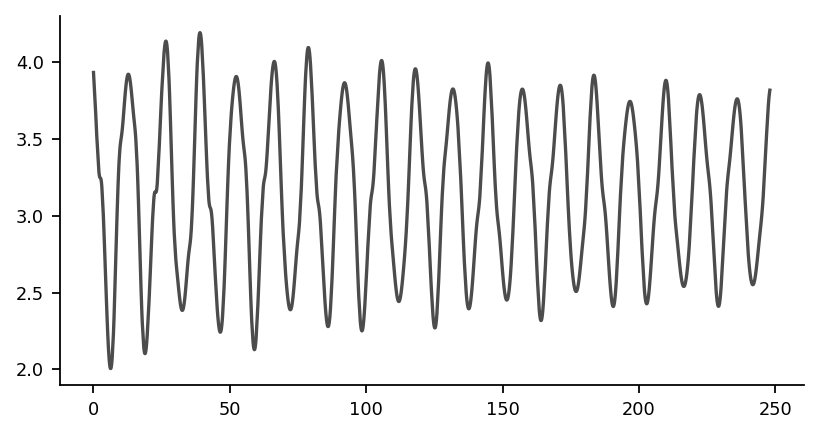

In [117]:
fig = plt.figure(figsize=(6, 3))
plt.plot(np.arange(len(The1))/1000, The1[:], alpha=0.7, c = 'black')

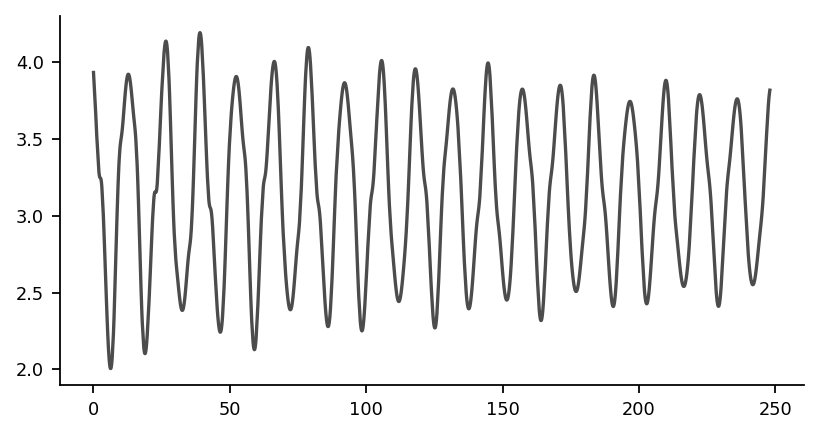

In [118]:
fig = plt.figure(figsize=(6, 3))
plt.plot(np.arange(len(The2))/1000, The1[:], alpha=0.7, c = 'black')

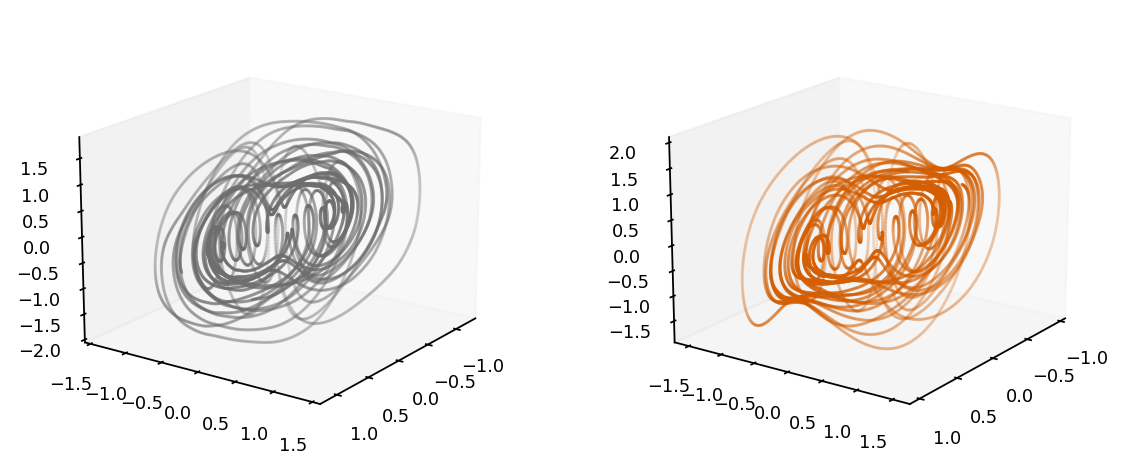

In [113]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

Zr = RobustScaler().fit_transform(F1_real_theta1)
Zl = RobustScaler().fit_transform(F2_real_theta1)

raw_color = "#6e6e6e"
log_color = "#D55E00"

fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")

ax1.scatter(Zr[::10,0], Zr[::10,1], Zr[::10,2], s=0.2, alpha=0.2, c=raw_color)
ax2.scatter(Zl[::10,0], Zl[::10,1], Zl[::10,2], s=0.2, alpha=0.2, c=log_color)
ax1.grid(False)
ax2.grid(False)

ax1.view_init(elev=18, azim=35)
ax2.view_init(elev=18, azim=35)

plt.tight_layout()
#plt.savefig("raw_vs_log_pca3d.pdf", dpi=300)
plt.show()


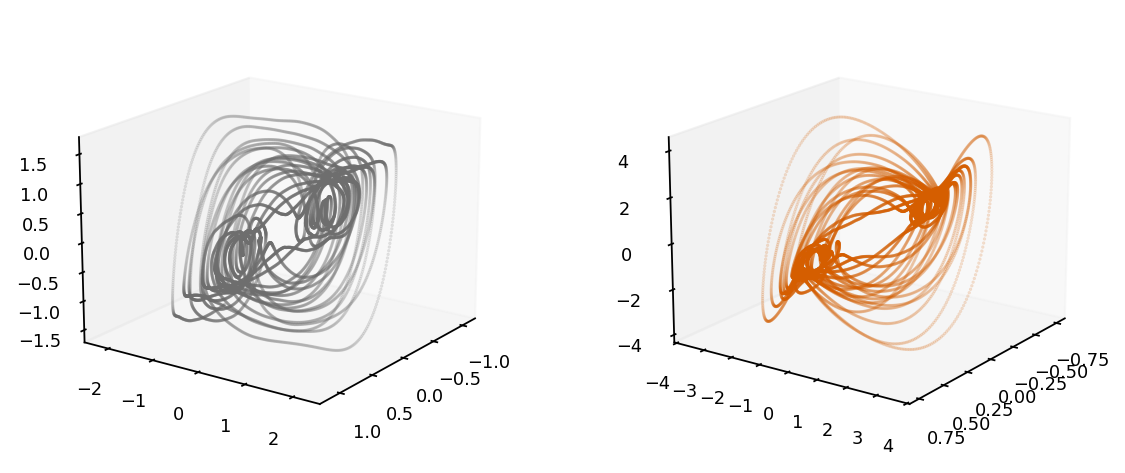

In [112]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

Zr = RobustScaler().fit_transform(F1_real_theta2)
Zl = RobustScaler().fit_transform(F2_real_theta2)

raw_color = "#6e6e6e"
log_color = "#D55E00"

fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_subplot(121, projection="3d")
ax2 = fig.add_subplot(122, projection="3d")

ax1.scatter(Zr[::10,0], Zr[::10,1], Zr[::10,2], s=0.2, alpha=0.2, c=raw_color)
ax2.scatter(Zl[::10,0], Zl[::10,1], Zl[::10,2], s=0.2, alpha=0.2, c=log_color)
ax1.grid(False)
ax2.grid(False)

ax1.view_init(elev=18, azim=35)
ax2.view_init(elev=18, azim=35)

plt.tight_layout()
#plt.savefig("raw_vs_log_pca3d.pdf", dpi=300)
plt.show()
